In [ ]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.nn.utils.rnn import pad_sequence

from dataloader import FastTensorDataLoader

## 1d Gaussian Score Matching

In [174]:
class Gaussian_1d(nn.Module):
    def __init__(self, dimensions):
        super(Gaussian_1d, self).__init__()
        self.mu = nn.Parameter(torch.randn(dimensions, dtype=torch.float64))
        self.sigma = nn.Parameter(torch.randn(dimensions, dtype=torch.float64))

    def forward(self, x):
        diff = x - self.mu
        return -0.5 * (diff**2/self.sigma**2)

In [175]:
def compute_psi_1d(x, model):
    x.requires_grad_()
    nn_output = model(x)
    psi = torch.autograd.grad(nn_output, x, create_graph=True)[0]
    return psi

In [176]:
def J_1d(x_t, model):
    T = len(x_t)
    total_sum = 0
    # norm_squared_list, norm_squared_real_list = [], []

    for t in range(T):
        x = x_t[t]
        psi_x_t = compute_psi_1d(x, model)

        divergence = torch.autograd.grad(psi_x_t.sum(), x, create_graph=True)[0].sum()
        norm_squared = (psi_x_t ** 2).sum()

        # Accumulate sum
        total_sum += 0.5 * norm_squared + divergence

    return total_sum / T

In [205]:
def optimize_theta_gaussian_1d(
        x_t_all, dim, num_epochs=1000, learning_rate_mu=1e-3,
        learning_rate_sigma=1e-4, clip_value=1.0,
    ):
    model = Gaussian_1d(dim)
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.Rprop(
        [
            {"params": [model.mu], "lr": learning_rate_mu},
            {"params": [model.sigma], "lr": learning_rate_sigma},
        ]
    )
    losses = []
    estimated_mus = []
    estimated_covs = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        x_t_tensor = torch.tensor(x_t_all, dtype=torch.float64)
        loss = J_1d(x_t_tensor, model)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()

        # print(f"Epoch {epoch}, mu: {model.mu}")
        # print(f"Epoch {epoch}, sigma: {model.sigma}")
        losses.append(loss.item())
        estimated_mus.append(model.mu.detach().numpy().copy())
        estimated_covs.append(model.sigma.detach().numpy().copy())

        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

    return model, losses, estimated_mus, estimated_covs

In [207]:
mean, std = 2, 2
x = torch.normal(mean=mean, std=std, size=(10000,))

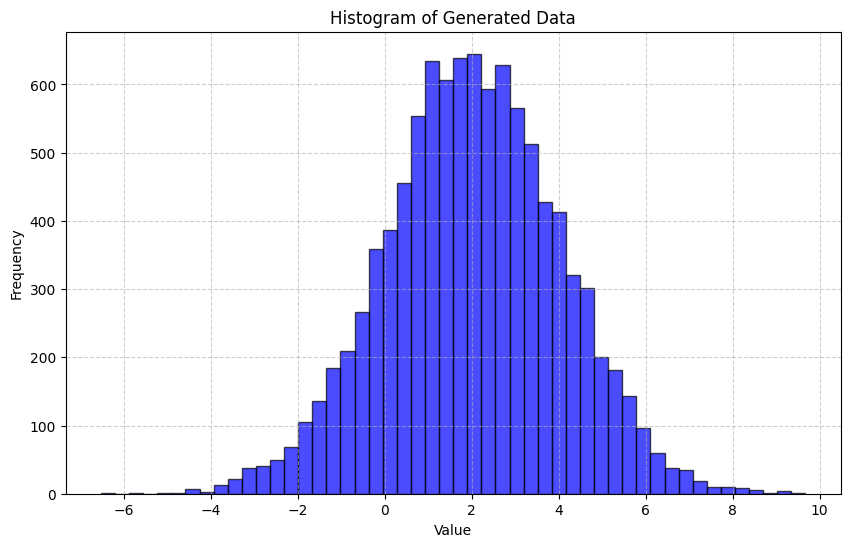

In [216]:
plt.figure(figsize=(10, 6))
plt.hist(x.numpy(), bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Generated Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [215]:
epochs = 50
model, losses, estimated_mus, estimated_covs = optimize_theta_gaussian_1d(x, 1, num_epochs=epochs, learning_rate_mu=1e-2)

C:\Users\79217\AppData\Local\Temp\ipykernel_11324\1213766117.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_t_tensor = torch.tensor(x_t_all, dtype=torch.float64)


Epoch 0/50, Loss: 3.1581074676330334
Epoch 1/50, Loss: 3.1379705008242005
Epoch 2/50, Loss: 3.1139157583797545
Epoch 3/50, Loss: 3.085207721515153
Epoch 4/50, Loss: 3.050984761789784
Epoch 5/50, Loss: 3.010243053715971
Epoch 6/50, Loss: 2.9618212146631304
Epoch 7/50, Loss: 2.904387499529769
Epoch 8/50, Loss: 2.8364324446763054
Epoch 9/50, Loss: 2.7562714171968015
Epoch 10/50, Loss: 2.6620637849440945
Epoch 11/50, Loss: 2.5518586559863214
Epoch 12/50, Loss: 2.423681712177279
Epoch 13/50, Loss: 2.275684061475205
Epoch 14/50, Loss: 2.1063828657218044
Epoch 15/50, Loss: 1.9150354985096338
Epoch 16/50, Loss: 1.702204973417478
Epoch 17/50, Loss: 1.4705951580860062
Epoch 18/50, Loss: 1.2262603990839054
Epoch 19/50, Loss: 0.9803254576185838
Epoch 20/50, Loss: 0.7513864060931095
Epoch 21/50, Loss: 0.5687968083359765
Epoch 22/50, Loss: 0.4770666157142225
Epoch 23/50, Loss: 0.54159637060013
Epoch 24/50, Loss: 0.5201099174443015
Epoch 25/50, Loss: 0.43447104032001144
Epoch 26/50, Loss: 0.393910857

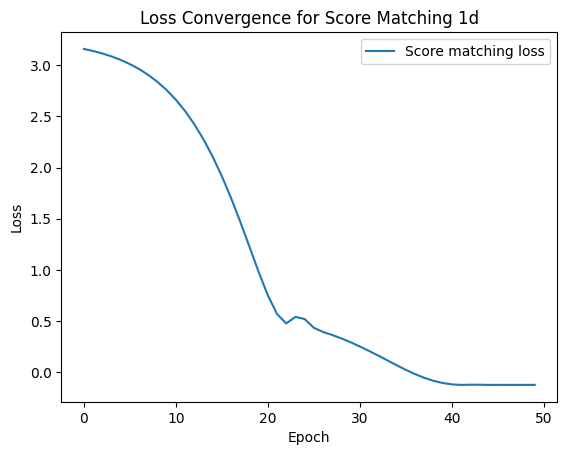

In [218]:
plt.plot(losses, label="Score matching loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence for Score Matching 1d')
plt.legend()
plt.show()

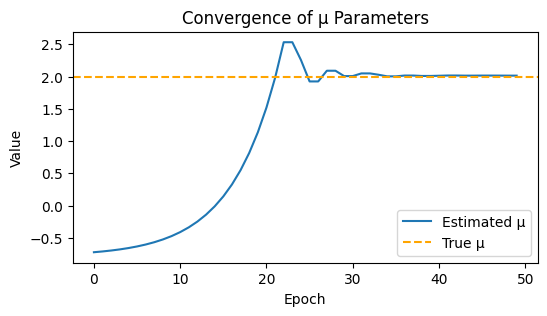

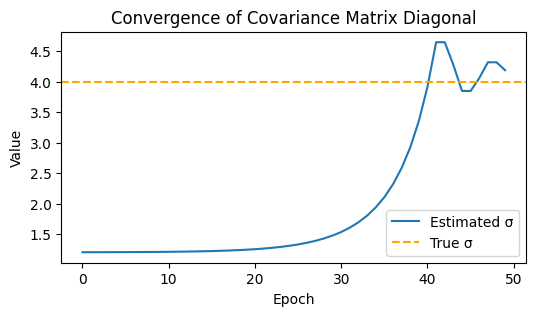

In [219]:
estimated_mus = np.array(estimated_mus)
plt.figure(figsize=(6, 3))
plt.plot(estimated_mus[:, 0], label="Estimated μ")
plt.axhline(mean, color='orange', linestyle='--', label="True μ")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of μ Parameters')
plt.show()

# Plot convergence of covariance matrix diagonal (variance terms)
plt.figure(figsize=(6, 3))
plt.plot([s**2 for s in estimated_covs], label="Estimated σ")
plt.axhline(std**2, color='orange', linestyle='--', label="True σ")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of Covariance Matrix Diagonal')
plt.show()

In [204]:
print("Final estimated μ:", estimated_mus[-1][0])
print("True μ:", mean)
print("\nFinal estimated Σ:\n", estimated_covs[-1][0]**2)
print("True σ:\n", std**2)

Final estimated μ: 2.0351647671726063
True μ: 2

Final estimated Σ:
 3.723310249931218
True σ:
 4


## Multivariate Gaussian Score Matching

### Gaussian Model

In [180]:
class Gaussian(nn.Module):
    def __init__(self, dimensions):
        super(Gaussian, self).__init__()
        self.mu = nn.Parameter(torch.randn(dimensions, dtype=torch.float64))
        self.M = nn.Parameter(torch.randn(size=[dimensions, dimensions], dtype=torch.float64))
        A = torch.randn(dimensions, dimensions, dtype=torch.float64)
        self.M = nn.Parameter(torch.mm(A, A.T))    
        self.M.data += dimensions * torch.eye(dimensions, dtype=torch.float64)
        # self.L = nn.Parameter(torch.randn(size=[dimensions, dimensions], dtype=torch.float64))
        # self.mu = nn.Parameter(torch.tensor([0.0] * dimensions, dtype=torch.float64))
        # self.L = nn.Parameter(torch.eye(dimensions, dtype=torch.float64))

    def forward(self, x):
        # cov = self.L @ self.L.T
        # cov_inv = torch.cholesky_inverse(torch.linalg.cholesky(cov))
        diff = x - self.mu
        return -0.5 * (diff.T @ self.M @ diff)

### Psi calculation (Score Matching & Analytical)

In [86]:
def compute_psi(x, model):
    nn_output = model(x)
    psi = torch.autograd.grad(nn_output, x, create_graph=True)[0]
    return psi

In [ ]:
def gaussian_psi(x, mu=torch.tensor([0.0, 0.0]), M=torch.eye(2, dtype=torch.float64)):
    return -M @ (x - mu)
    # return -torch.cholesky_inverse(torch.linalg.cholesky(cov)) @ (x - mu)

### Divergence calculation (Jacobian)

In [ ]:
def compute_divergence_jacobian(x, model):
    jacobian = torch.autograd.functional.jacobian(lambda x: compute_psi(x, model), x)
    divergence = jacobian.diagonal(dim1=-2, dim2=-1).sum(-1)  # Sum diagonal elements
    return divergence

### Objective Funciton J Calculation (Score Matching & Analytical) 

In [ ]:
def J(x_t, model):
    T = len(x_t)
    total_sum, real_sum = 0, 0

    for t in range(T):
        x = x_t[t]
        x.requires_grad_()
        psi_x_t = compute_psi(x, model)
        
        psi_x_t_real = gaussian_psi(x, model.mu.detach(), model.M.detach())
        if not torch.allclose(psi_x_t, psi_x_t_real, atol=1e-4):
            raise ValueError(
                f"Calculated psi value {psi_x_t} \
                is different from the analytical solution {psi_x_t_real}"
                )
        
        # divergence = torch.autograd.grad(psi_x_t.sum(), x, create_graph=True)[0].sum()
        divergence = compute_divergence_jacobian(x, model)
        norm_squared = (psi_x_t ** 2).sum()
        # divergence = torch.autograd.grad(psi_x_t_real.sum(), x, create_graph=True)[0].sum()
        # norm_squared = (psi_x_t_real ** 2).sum()
        
        divergence_real, norm_squared_real = gaussian_J(x, model.mu.detach(), model.M.detach())

        if not torch.allclose(divergence, divergence_real, atol=1e-4):
            raise ValueError(
                f"Calculated divergence value {divergence} \
                is different from the analytical solution {divergence_real}"
                )
        if not torch.allclose(norm_squared, norm_squared_real, atol=1e-4):
            raise ValueError(
                f"Calculated norm squared value {norm_squared} \
                is different from the analytical solution {norm_squared_real}"
                )
        
        # Accumulate sums
        real_sum += 0.5 * norm_squared_real + divergence_real
        total_sum += 0.5 * norm_squared + divergence

    # print(f"Divergence (autograd): {divergence}")
    # print(f"Divergence (analytical): {divergence_real}")

    return total_sum / T, real_sum / T

In [90]:
def gaussian_J(x_t, mu=torch.tensor([0.0, 0.0]), M=torch.eye(2, dtype=torch.float32)):
    # cov = L @ L.T
    # cov_inv = torch.cholesky_inverse(torch.linalg.cholesky(cov))
    diff = x_t - mu
    trace_term = -torch.trace(M)
    quadratic_term = diff.T @ M @ M @ diff
    return trace_term, quadratic_term

### Optimization Loop (Normal & Batch)

In [187]:
def optimize_theta_gaussian(
        x_t_all, dim, num_epochs=1000, learning_rate_mu=1e-3,
        learning_rate_M=1e-4, l2_reg=1e-4, clip_value=1.0,
    ):
    model = Gaussian(dim)
    # optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate_mu)
    optimizer = torch.optim.Rprop(
        [
            {"params": [model.mu], "lr": learning_rate_mu},
            {"params": [model.M], "lr": learning_rate_M},
        ]
    )
    losses = []
    real_losses = []
    estimated_mus = []
    estimated_covs = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        x_t_tensor = torch.tensor(x_t_all, dtype=torch.float64)
        loss, real_loss = J(x_t_tensor, model)

        # l2_loss = sum((param ** 2).sum() for param in model.parameters())
        # loss += l2_reg * l2_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        # print(f"Epoch {epoch}, mu: {model.mu}")
        # print(f"Epoch {epoch}, cov: {model.M}")
        optimizer.step()

        losses.append(loss.item())
        real_losses.append(real_loss.item())
        estimated_mus.append(model.mu.detach().numpy().copy())
        estimated_covs.append(model.M.detach().numpy().copy())

        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

    return model, losses, real_losses, estimated_mus, estimated_covs

In [183]:
def optimize_theta_gaussian_batch(
        loader_train, dim, num_epochs=1000, learning_rate_mu=1e-3,
        learning_rate_M=1e-4, l2_reg=1e-4, clip_value=1.0,
    ):
    model = Gaussian(dim)
    optimizer = torch.optim.Rprop(
        [
            {"params": [model.mu], "lr": learning_rate_mu},
            {"params": [model.M], "lr": learning_rate_M},
        ]
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)
    
    losses = []
    real_losses = []
    estimated_mus = []
    estimated_covs = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        epoch_real_loss = 0

        # Iterate over batches
        for b, X_batch in enumerate(loader_train):
            optimizer.zero_grad()

            # Assume J() computes the loss for the batch
            loss, real_loss = J(X_batch[0], model)

            # Optional: Add L2 regularization if needed
            # l2_loss = sum((param ** 2).sum() for param in model.parameters())
            # loss += l2_reg * l2_loss

            # Backpropagation and parameter update
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            epoch_loss += loss.item()
            epoch_real_loss += real_loss.item()

            # Update scheduler after each batch
            scheduler.step(loss)

        # Record the average losses per epoch
        losses.append(epoch_loss / len(loader_train))
        real_losses.append(epoch_real_loss / len(loader_train))
        estimated_mus.append(model.mu.detach().numpy().copy())
        estimated_covs.append(model.M.detach().numpy().copy())

        print(f"Epoch {epoch}/{num_epochs}, Loss: {epoch_loss / len(loader_train)}")

    return model, losses, real_losses, estimated_mus, estimated_covs

### Data Generation

In [182]:
def generate_multivariate_gaussian_data(mean, cov, num_samples):
    np.random.seed(123)
    data = np.random.multivariate_normal(mean, cov, num_samples)
    return data

In [189]:
n = 10000
mu = np.array([0.0, 0.0])
cov = np.array([[1.0, 0.0], [0.0, 1.0]])
# mu = np.array([0.0, 0.0, 0.0])
# cov = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
x_t_all = generate_multivariate_gaussian_data(mu, cov, n)
dim = x_t_all.shape[1]

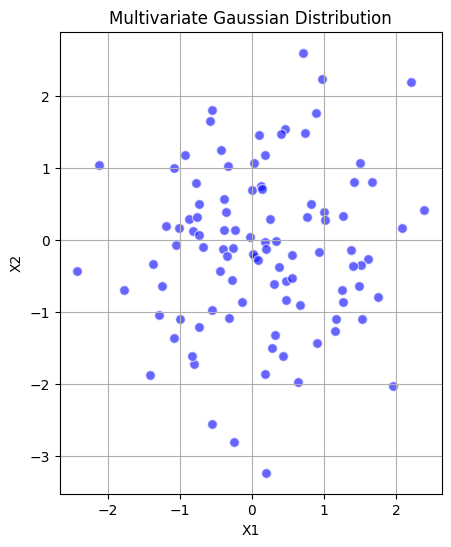

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(x_t_all[:, 0], x_t_all[:, 1], c='blue', alpha=0.6, edgecolors='w', s=50)
plt.title("Multivariate Gaussian Distribution")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### Batch Data Generation

In [184]:
def generate_multivariate_gaussian_data_batch(mean, cov, num_samples, num_points):
    np.random.seed(123)
    data = np.random.multivariate_normal(mean, cov, (num_samples, num_points))
    return data

In [185]:
num_samples = 100  # Number of samples
num_points = 1000  # Number of points in each sample (each point is 2D)

# Mean vector (2D) and covariance matrix (2x2 identity matrix)
mu = np.zeros(2)  # Mean vector of shape (2,) for 2D Gaussian
cov = np.eye(2)   # Covariance matrix of shape (2, 2), identity matrix for simplicity

# Generate the multivariate Gaussian samples (each sample contains 1000 points in 2D)
x_t_all = generate_multivariate_gaussian_data_batch(mu, cov, num_samples, num_points)

# Convert the generated samples into tensors (each sample is an array of 1000 points in 2D)
samples_tensors = [torch.tensor(s, dtype=torch.float32) for s in x_t_all]

# Since all samples are the same length (1000), padding isn't necessary in this case
# but we will still use pad_sequence for demonstration purposes
X = pad_sequence(samples_tensors, batch_first=True, padding_value=0)

# Split into training and validation sets (80 for training, 20 for validation)
X_train = X[:80]  # Use the first 80 samples for training
X_val = X[80:100]  # Use the last 20 samples for validation

# Display the shapes of the training and validation sets
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: torch.Size([80, 1000, 2])
Validation data shape: torch.Size([20, 1000, 2])


In [177]:
loader_train = FastTensorDataLoader(X_train, batch_size=10, shuffle=True)
loader_val = FastTensorDataLoader(X_val, batch_size=10, shuffle=True)

### Training Loop

In [ ]:
epochs = 100
model, losses, real_losses, estimated_mus, estimated_covs = optimize_theta_gaussian(
    x_t_all, dim, num_epochs=epochs, learning_rate_mu=1e-3, learning_rate_M= 1e-5
    )

Epoch 0/100, Loss: 13.987658864768656
Epoch 1/100, Loss: 13.971499519292792
Epoch 2/100, Loss: 13.952182852096472
Epoch 3/100, Loss: 13.92911019676616


### Data Saving

In [95]:
os.makedirs('data', exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

losses_file = f"data/run_{timestamp}_losses_epoch_{epochs}.npy"
mus_file = f"data/run_{timestamp}_mus_epoch_{epochs}.npy"
covs_file = f"data/run_{timestamp}_covs_epoch_{epochs}.npy"

np.save(losses_file, losses)
np.save(mus_file, estimated_mus)
np.save(covs_file, estimated_covs)

print(f"Saved files: {losses_file}, {mus_file}, {covs_file}")

Saved files: data/run_20241125_144146_losses_epoch_100.npy, data/run_20241125_144146_mus_epoch_100.npy, data/run_20241125_144146_covs_epoch_100.npy


### Loss and Parameters Plots

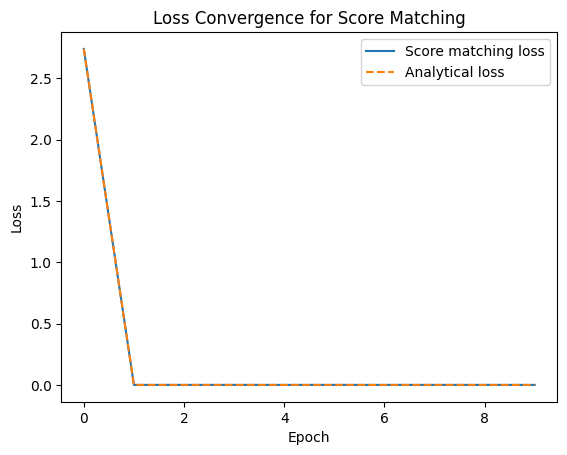

In [143]:
plt.plot(losses, label="Score matching loss")
plt.plot(real_losses, label="Analytical loss", linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence for Score Matching')
plt.legend()
plt.show()

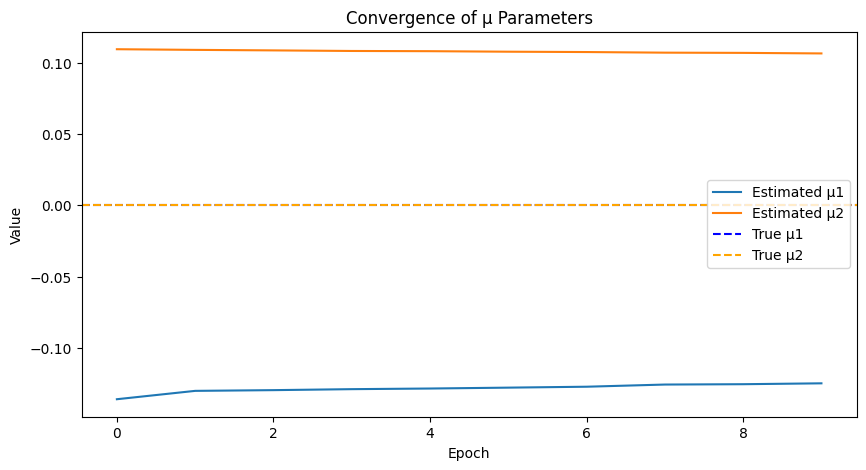

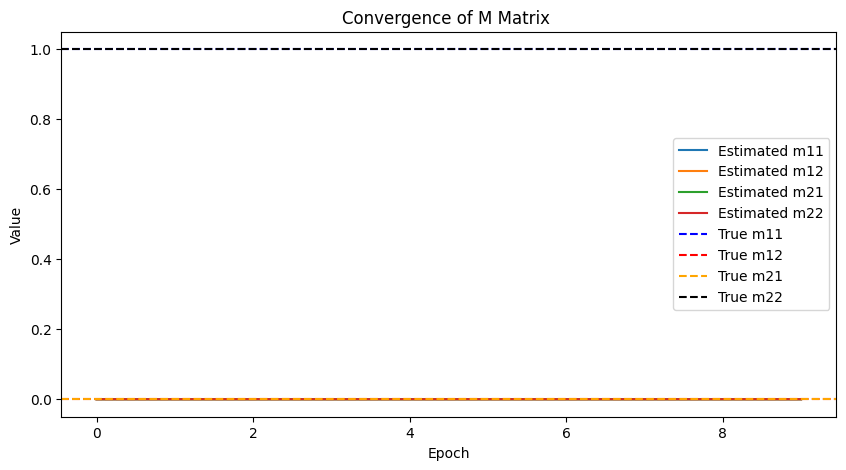

In [144]:
estimated_mus = np.array(estimated_mus)
plt.figure(figsize=(10, 5))
plt.plot(estimated_mus[:, 0], label="Estimated μ1")
plt.plot(estimated_mus[:, 1], label="Estimated μ2")
plt.axhline(mu[0], color='blue', linestyle='--', label="True μ1")
plt.axhline(mu[1], color='orange', linestyle='--', label="True μ2")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of μ Parameters')
plt.show()

# Plot convergence of covariance matrix diagonal (variance terms)
estimated_covs_diag = np.array(estimated_covs)
plt.figure(figsize=(10, 5))
plt.plot(estimated_covs_diag[:, 0, 0], label="Estimated m11")
plt.plot(estimated_covs_diag[:, 0, 1], label="Estimated m12")
plt.plot(estimated_covs_diag[:, 1, 0], label="Estimated m21")
plt.plot(estimated_covs_diag[:, 1, 1], label="Estimated m22")
plt.axhline(cov[0, 0], color='blue', linestyle='--', label="True m11")
plt.axhline(cov[0, 1], color='red', linestyle='--', label="True m12")
plt.axhline(cov[1, 0], color='orange', linestyle='--', label="True m21")
plt.axhline(cov[1, 1], color='black', linestyle='--', label="True m22")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of M Matrix ')
plt.show()

### Final Parameter estimations

In [121]:
print("Final estimated μ:", estimated_mus[280])
print("True μ:", mu)
print("\nFinal estimated Σ:\n", torch.linalg.inv(torch.tensor(estimated_covs[280])))
print("True Σ:\n", cov)

Final estimated μ: [ 0.17628634 -0.06996982]
True μ: [0. 0.]

Final estimated Σ:
 tensor([[1.1123, 0.3193],
        [0.3193, 1.4147]], dtype=torch.float64)
True Σ:
 [[1. 0.]
 [0. 1.]]


In [115]:
model_mu = torch.tensor(estimated_mus[-1])
model_cov = torch.linalg.inv(torch.tensor(estimated_covs[-1]))
model_x_t = generate_multivariate_gaussian_data(model_mu, model_cov, n)

C:\Users\79217\AppData\Local\Temp\ipykernel_29000\2233108499.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  data = np.random.multivariate_normal(mean, cov, num_samples)


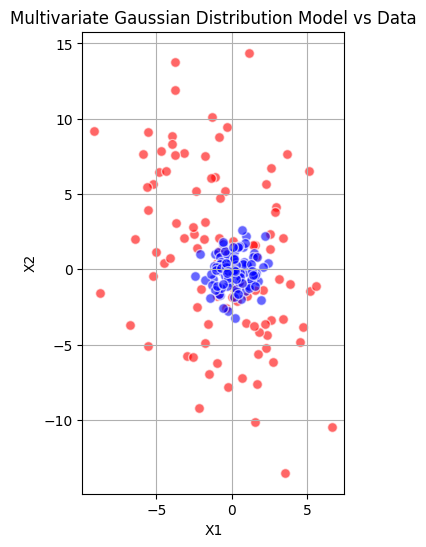

In [116]:
plt.figure(figsize=(8, 6))
plt.scatter(model_x_t[:, 0], model_x_t[:, 1], c='red', alpha=0.6, edgecolors='w', s=50)

plt.scatter(x_t_all[:, 0], x_t_all[:, 1], c='blue', alpha=0.6, edgecolors='w', s=50)
plt.title("Multivariate Gaussian Distribution Model vs Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### Jacobian, Autograd and Analytical Solution comparison

In [74]:
def compare_grad_jacobian(x, model):
    psi_x_t = compute_psi(x, model)
        
    divergence_autograd = torch.autograd.grad(psi_x_t.sum(), x, create_graph=True)[0].sum()
    print(torch.autograd.grad(psi_x_t.sum(), x, create_graph=True))
    divergence_jacobian = compute_divergence_jacobian(x, model)
        
    divergence_analytical, _ = gaussian_J(x, model.mu.detach(), model.M.detach())

    return divergence_autograd, divergence_jacobian, divergence_analytical

In [83]:
model = Gaussian(dim)
print(model.mu, model.M)
x = [1.0856, -0.9973]
x_tensor = torch.tensor(x, dtype=torch.float64, requires_grad=True)
div_a, div_j, div_an = compare_grad_jacobian(x_tensor, model)

Parameter containing:
tensor([-0.8318, -0.3794], dtype=torch.float64, requires_grad=True) Parameter containing:
tensor([[3.8054, 1.7804],
        [1.7804, 4.1760]], dtype=torch.float64, requires_grad=True)
(tensor([-5.5858, -5.9564], dtype=torch.float64, grad_fn=<AddBackward0>),)


In [84]:
print(f"Divergence (autograd): {div_a}")
print(f"Divergence (Jacobian): {div_j}")
print(f"Divergence (analytical): {div_an}")

Divergence (autograd): -11.542208769694861
Divergence (Jacobian): -7.981347675216129
Divergence (analytical): -7.981347675216129
